In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import model_utils
utils = model_utils.utils()

In [2]:
train_dir = '/Volumes/T7/herbarium-2022-fgvc9/train_images/'
test_dir = '/Volumes/T7/herbarium-2022-fgvc9/test_images/'

with open('/Volumes/T7/herbarium-2022-fgvc9/train_metadata.json') as json_file:
    train_meta = json.load(json_file)
with open("/Volumes/T7/herbarium-2022-fgvc9/test_metadata.json") as json_file:
    test_meta = json.load(json_file)

image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

test_ids = [image['image_id'] for image in test_meta]
test_dirs = [test_dir + image['file_name'] for image in test_meta]

train_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

test_df = pd.DataFrame({
    "test_id" : test_ids,
    "test_dir" : test_dirs
})

train_df

,image_id,image_dir,category,genus
0,00000__001,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
1,00000__002,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
2,00000__003,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
3,00000__004,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
4,00000__005,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
...,...,...,...,...
839767,15504__032,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584
839768,15504__033,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584
839769,15504__035,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584
839770,15504__036,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584


In [3]:
genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
train_df['genus'] = train_df['genus'].map(genus_map)
train_df

,image_id,image_dir,category,genus
0,00000__001,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
1,00000__002,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
2,00000__003,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
3,00000__004,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
4,00000__005,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
...,...,...,...,...
839767,15504__032,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum
839768,15504__033,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum
839769,15504__035,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum
839770,15504__036,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum


In [4]:
train_df = train_df[:5850]

In [5]:
N_Classes = train_df['category'].nunique()
N_Classes

101

In [6]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values

class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        #x = Image.open(self.fnames[index])
        x = cv2.imread(self.fnames[index])
        
        
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset = GetData(X_Train, Y_Train, utils.Transform)


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

def split_indices(n, val_pct=0.1, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_indices, val_indices = split_indices(len(trainset))

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(trainset, batch_size=utils.BATCH, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(trainset, batch_size=utils.BATCH, sampler=val_sampler)

In [8]:
len(train_dl)

165

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.densenet169(pretrained=True)

print(model.classifier.in_features) 
print(model.classifier.out_features)

for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, N_Classes)
model.classifier = last_layer

if torch.cuda.is_available():
    model.cuda()
print(model.classifier.out_features)    

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())


1664
1000
101


In [15]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            acc = ((output.argmax(dim=1) == labels).float().mean())
            train_acc += acc
            train_loss += loss
            del output
            del loss
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)


In [12]:
model = torch.load('./model.pth')

In [16]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
for epoch in range(utils.EPOCHS):
    train_acc, train_loss = train(train_dl, model, criterion, optimizer, scaler, device=device)
    torch.save(model, './model.pth')
    eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

100%|██████████| 19/19 [01:39<00:00,  5.25s/it]



Epoch 1 | Train Acc: 14.723708152770996 | Train Loss: 3.9076082706451416
	 Val Acc: 29.3128662109375 | Val Loss: 3.1049604415893555


100%|██████████| 19/19 [01:39<00:00,  5.25s/it]



Epoch 2 | Train Acc: 41.604278564453125 | Train Loss: 2.6064374446868896
	 Val Acc: 36.71417999267578 | Val Loss: 2.6410915851593018


100%|██████████| 19/19 [01:41<00:00,  5.34s/it]



Epoch 3 | Train Acc: 53.18292999267578 | Train Loss: 2.029475212097168
	 Val Acc: 37.35380172729492 | Val Loss: 2.399686813354492


100%|██████████| 19/19 [01:39<00:00,  5.22s/it]



Epoch 4 | Train Acc: 61.476158142089844 | Train Loss: 1.6736091375350952
	 Val Acc: 40.917396545410156 | Val Loss: 2.235095977783203


100%|██████████| 19/19 [01:38<00:00,  5.21s/it]



Epoch 5 | Train Acc: 67.09893035888672 | Train Loss: 1.421256184577942
	 Val Acc: 42.19663619995117 | Val Loss: 2.1590614318847656


100%|██████████| 19/19 [01:40<00:00,  5.28s/it]



Epoch 6 | Train Acc: 71.6544189453125 | Train Loss: 1.2503597736358643
	 Val Acc: 44.206871032714844 | Val Loss: 2.0895731449127197


100%|██████████| 19/19 [01:39<00:00,  5.24s/it]



Epoch 7 | Train Acc: 75.38993072509766 | Train Loss: 1.1004281044006348
	 Val Acc: 46.50950241088867 | Val Loss: 2.042179584503174


100%|██████████| 19/19 [01:39<00:00,  5.23s/it]



Epoch 8 | Train Acc: 77.91332244873047 | Train Loss: 0.9813329577445984
	 Val Acc: 46.16228103637695 | Val Loss: 2.046283006668091


100%|██████████| 19/19 [01:39<00:00,  5.22s/it]



Epoch 9 | Train Acc: 81.698974609375 | Train Loss: 0.8724714517593384
	 Val Acc: 45.32163619995117 | Val Loss: 2.0078742504119873


100%|██████████| 19/19 [01:38<00:00,  5.19s/it]


Epoch 10 | Train Acc: 83.40129089355469 | Train Loss: 0.8063929677009583
	 Val Acc: 45.08406448364258 | Val Loss: 2.0288753509521484
CPU times: user 3h 24min 59s, sys: 1h 20min 40s, total: 4h 45min 40s
Wall time: 3h 46s


In [17]:
test = torch.load('./model.pth')

In [19]:
a,b = evaluate(val_dl, test, criterion, device)

100%|██████████| 19/19 [01:50<00:00,  5.84s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


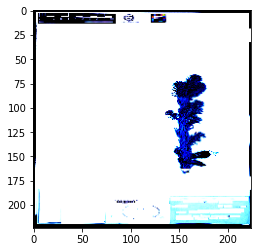

In [26]:
plt.imshow(trainset[0][0].permute(1,2,0))